# Notebook 03: Model Setup and Inference (Clean Data)
## Benchmarking SAM & MedSAM Robustness under Noisy Abdominal CT Conditions

**Author:** Hoang Le Chau   
**Date:** January 2026

---

### Objective
Setup and run inference for SAM-based models on clean medical images:
1. Setup SAM, SAM2, and MedSAM models
2. Generate automatic segmentation masks
3. Save predictions for evaluation

This establishes baseline performance before noisy data evaluation.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import cv2
import torch
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-paper')
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-80GB


### 1. Mount Drive and Setup Paths

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = Path('/content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/')
OUTPUT_PATH = BASE_PATH / 'SAM_Robustness_Study'
NOISY_DATA_PATH = OUTPUT_PATH / 'noisy_data'
PREDICTIONS_PATH = OUTPUT_PATH / 'predictions'
PREDICTIONS_PATH.mkdir(exist_ok=True)

MODELS_PATH = OUTPUT_PATH / 'models'
MODELS_PATH.mkdir(exist_ok=True)

print(f"Data path: {NOISY_DATA_PATH}")
print(f"Predictions will be saved to: {PREDICTIONS_PATH}")
print(f"Models will be saved to: {MODELS_PATH}")

Mounted at /content/drive
Data path: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/noisy_data
Predictions will be saved to: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/predictions
Models will be saved to: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/models


### 2. Install Required Libraries

In [3]:
!pip install segment-anything-py
!pip install git+https://github.com/facebookresearch/segment-anything-2.git
!pip install opencv-python-headless
!pip install monai

print("\nLibraries installed successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 4.1 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-zdytbnpc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-zdytbnpc
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.1 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=504951 sha256=ebb94a8c10a911e1ef692d2c1814abe4e3972ecc90f383e886d05c84259e12f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-qugmepwr/whee

### 3. Download Model Checkpoints

In [4]:
import urllib.request

def download_checkpoint(url, save_path):
    """
    Download model checkpoint if not already present.

    Args:
        url: Download URL
        save_path: Path to save checkpoint
    """
    if not save_path.exists():
        print(f"Downloading {save_path.name}...")
        urllib.request.urlretrieve(url, save_path)
        print(f"Downloaded to {save_path}")
    else:
        print(f"{save_path.name} already exists")

sam_vit_h_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
sam_checkpoint = MODELS_PATH / "sam_vit_h_4b8939.pth"
download_checkpoint(sam_vit_h_url, sam_checkpoint)

medsam_url = "https://drive.google.com/file/d/1UAmWL88roYR7wKlnApw5Bcuzf2iQgk6_/view?usp=drive_link"
medsam_checkpoint = MODELS_PATH / "medsam_vit_b.pth"
download_checkpoint(medsam_url, medsam_checkpoint)

print("\nCheckpoints ready")

sam_vit_h_4b8939.pth already exists
medsam_vit_b.pth already exists

Checkpoints ready


### 4. Load Data

In [5]:
def load_clean_data(dataset_name):
    """
    Load clean dataset for inference.

    Args:
        dataset_name: Name of dataset ('liver' or 'spleen')

    Returns:
        Dictionary with images, labels, and metadata
    """
    data_path = NOISY_DATA_PATH / dataset_name / 'clean'

    images = np.load(data_path / 'images.npy')
    labels = np.load(data_path / 'labels.npy')
    metadata = pd.read_csv(data_path / 'metadata.csv')

    return {
        'images': images,
        'labels': labels,
        'metadata': metadata
    }

liver_data = load_clean_data('liver')
spleen_data = load_clean_data('spleen')

print(f"Liver: {liver_data['images'].shape}")
print(f"Spleen: {spleen_data['images'].shape}")

Liver: (50, 512, 512)
Spleen: (50, 512, 512)


### 5. Initialize SAM Models

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

class SAMPredictor:
    """
    Wrapper class for SAM-based models.
    """

    def __init__(self, model_type='sam', checkpoint_path=None, device='cuda'):
        """
        Initialize SAM predictor.

        Args:
            model_type: Type of model ('sam', 'sam2', 'medsam')
            checkpoint_path: Path to model checkpoint
            device: Device to run inference on
        """
        self.model_type = model_type
        self.device = device

        if model_type == 'sam':
            self.model = sam_model_registry['vit_h'](checkpoint=str(checkpoint_path))
            self.model.to(device)

            self.mask_generator = SamAutomaticMaskGenerator(
                model=self.model,
                points_per_side=32,
                pred_iou_thresh=0.8,
                stability_score_thresh=0.9,
                crop_n_layers=1,
                crop_n_points_downscale_factor=2,
                min_mask_region_area=100,
            )

        elif model_type == 'medsam':
            self.model = sam_model_registry['vit_b'](checkpoint=str(checkpoint_path))
            self.model.to(device)

            self.mask_generator = SamAutomaticMaskGenerator(
                model=self.model,
                points_per_side=32,
                pred_iou_thresh=0.8,
                stability_score_thresh=0.9,
                crop_n_layers=1,
                crop_n_points_downscale_factor=2,
                min_mask_region_area=100,
            )

    def preprocess_image(self, image):
        """
        Preprocess medical image for SAM.

        Args:
            image: Input image (2D numpy array)

        Returns:
            RGB image for SAM
        """
        img_min = image.min()
        img_max = image.max()
        if img_max - img_min > 0:
            image_norm = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        else:
            image_norm = np.zeros_like(image, dtype=np.uint8)

        image_rgb = cv2.cvtColor(image_norm, cv2.COLOR_GRAY2RGB)
        return image_rgb

    def generate_mask(self, image):
        """
        Generate segmentation mask using automatic mask generation.

        Args:
            image: Input image

        Returns:
            Combined binary mask
        """
        image_rgb = self.preprocess_image(image)

        masks = self.mask_generator.generate(image_rgb)

        if len(masks) == 0:
            return np.zeros(image.shape, dtype=np.uint8)

        sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)

        combined_mask = np.zeros(image.shape, dtype=np.uint8)
        for mask_dict in sorted_masks[:5]:
            combined_mask = np.logical_or(combined_mask, mask_dict['segmentation']).astype(np.uint8)

        return combined_mask

print("SAMPredictor class defined")

SAMPredictor class defined


### 6. Initialize Models

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print("\nInitializing SAM...")
sam_predictor = SAMPredictor(
    model_type='sam',
    checkpoint_path=sam_checkpoint,
    device=device
)

print("\nInitializing MedSAM...")
medsam_predictor = SAMPredictor(
    model_type='medsam',
    checkpoint_path=medsam_checkpoint,
    device=device
)

models = {
    'SAM': sam_predictor,
    'MedSAM': medsam_predictor
}

print("\nAll models initialized successfully")

Using device: cuda

Initializing SAM...

Initializing MedSAM...

All models initialized successfully


### 7. Run Inference on Clean Data

In [8]:
def run_inference(images, labels, metadata, models, dataset_name, save_path):
    """
    Run inference with all models and save predictions.

    Args:
        images: Array of images
        labels: Ground truth labels
        metadata: Metadata DataFrame
        models: Dictionary of model predictors
        dataset_name: Name of dataset
        save_path: Path to save predictions

    Returns:
        Dictionary of predictions for each model
    """
    predictions = {}

    for model_name, predictor in models.items():
        print(f"\nRunning {model_name} on {dataset_name} (clean)...")

        model_predictions = []

        for idx, image in enumerate(tqdm(images, desc=f"{model_name} inference")):
            try:
                pred_mask = predictor.generate_mask(image)
                model_predictions.append(pred_mask)
            except Exception as e:
                print(f"Error processing image {idx}: {e}")
                model_predictions.append(np.zeros_like(image, dtype=np.uint8))

        predictions[model_name] = np.array(model_predictions)

        model_save_path = save_path / dataset_name.lower() / 'clean' / model_name.lower()
        model_save_path.mkdir(exist_ok=True, parents=True)

        np.save(model_save_path / 'predictions.npy', predictions[model_name])
        np.save(model_save_path / 'ground_truth.npy', labels)
        metadata.to_csv(model_save_path / 'metadata.csv', index=False)

        print(f"Saved {model_name} predictions to {model_save_path}")

    return predictions

print("Running inference on Liver dataset...")
liver_predictions = run_inference(
    liver_data['images'],
    liver_data['labels'],
    liver_data['metadata'],
    models,
    'Liver',
    PREDICTIONS_PATH
)

print("\nRunning inference on Spleen dataset...")
spleen_predictions = run_inference(
    spleen_data['images'],
    spleen_data['labels'],
    spleen_data['metadata'],
    models,
    'Spleen',
    PREDICTIONS_PATH
)

print("\nInference complete!")

Running inference on Liver dataset...

Running SAM on Liver (clean)...


SAM inference: 100%|██████████| 50/50 [04:03<00:00,  4.87s/it]


Saved SAM predictions to /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/predictions/liver/clean/sam

Running MedSAM on Liver (clean)...


MedSAM inference:   2%|▏         | 1/50 [00:02<01:41,  2.06s/it]

Error processing image 0: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:   4%|▍         | 2/50 [00:04<01:38,  2.05s/it]

Error processing image 1: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:   6%|▌         | 3/50 [00:06<01:36,  2.05s/it]

Error processing image 2: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:   8%|▊         | 4/50 [00:08<01:34,  2.06s/it]

Error processing image 3: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  10%|█         | 5/50 [00:10<01:32,  2.06s/it]

Error processing image 4: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  12%|█▏        | 6/50 [00:12<01:30,  2.06s/it]

Error processing image 5: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  14%|█▍        | 7/50 [00:14<01:28,  2.05s/it]

Error processing image 6: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  16%|█▌        | 8/50 [00:16<01:26,  2.05s/it]

Error processing image 7: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  18%|█▊        | 9/50 [00:18<01:24,  2.05s/it]

Error processing image 8: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  20%|██        | 10/50 [00:20<01:22,  2.05s/it]

Error processing image 9: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  22%|██▏       | 11/50 [00:22<01:20,  2.05s/it]

Error processing image 10: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  24%|██▍       | 12/50 [00:24<01:17,  2.05s/it]

Error processing image 11: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  26%|██▌       | 13/50 [00:26<01:15,  2.05s/it]

Error processing image 12: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  28%|██▊       | 14/50 [00:28<01:13,  2.05s/it]

Error processing image 13: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  30%|███       | 15/50 [00:30<01:11,  2.05s/it]

Error processing image 14: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  32%|███▏      | 16/50 [00:32<01:09,  2.05s/it]

Error processing image 15: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  34%|███▍      | 17/50 [00:34<01:07,  2.05s/it]

Error processing image 16: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  36%|███▌      | 18/50 [00:36<01:05,  2.05s/it]

Error processing image 17: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  38%|███▊      | 19/50 [00:38<01:03,  2.05s/it]

Error processing image 18: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  40%|████      | 20/50 [00:41<01:01,  2.05s/it]

Error processing image 19: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  42%|████▏     | 21/50 [00:43<00:59,  2.05s/it]

Error processing image 20: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  44%|████▍     | 22/50 [00:45<00:57,  2.05s/it]

Error processing image 21: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  46%|████▌     | 23/50 [00:47<00:55,  2.05s/it]

Error processing image 22: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  48%|████▊     | 24/50 [00:49<00:53,  2.05s/it]

Error processing image 23: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  50%|█████     | 25/50 [00:51<00:51,  2.05s/it]

Error processing image 24: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  52%|█████▏    | 26/50 [00:53<00:49,  2.04s/it]

Error processing image 25: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  54%|█████▍    | 27/50 [00:55<00:47,  2.05s/it]

Error processing image 26: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  56%|█████▌    | 28/50 [00:57<00:45,  2.05s/it]

Error processing image 27: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  58%|█████▊    | 29/50 [00:59<00:42,  2.05s/it]

Error processing image 28: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  60%|██████    | 30/50 [01:01<00:40,  2.04s/it]

Error processing image 29: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  62%|██████▏   | 31/50 [01:03<00:38,  2.04s/it]

Error processing image 30: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  64%|██████▍   | 32/50 [01:05<00:36,  2.04s/it]

Error processing image 31: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  66%|██████▌   | 33/50 [01:07<00:34,  2.05s/it]

Error processing image 32: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  68%|██████▊   | 34/50 [01:09<00:32,  2.05s/it]

Error processing image 33: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  70%|███████   | 35/50 [01:11<00:30,  2.05s/it]

Error processing image 34: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  72%|███████▏  | 36/50 [01:13<00:28,  2.05s/it]

Error processing image 35: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  74%|███████▍  | 37/50 [01:15<00:26,  2.05s/it]

Error processing image 36: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  76%|███████▌  | 38/50 [01:17<00:24,  2.05s/it]

Error processing image 37: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  78%|███████▊  | 39/50 [01:19<00:22,  2.05s/it]

Error processing image 38: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  80%|████████  | 40/50 [01:21<00:20,  2.05s/it]

Error processing image 39: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  82%|████████▏ | 41/50 [01:24<00:18,  2.05s/it]

Error processing image 40: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  84%|████████▍ | 42/50 [01:26<00:16,  2.05s/it]

Error processing image 41: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  86%|████████▌ | 43/50 [01:28<00:14,  2.05s/it]

Error processing image 42: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  88%|████████▊ | 44/50 [01:30<00:12,  2.05s/it]

Error processing image 43: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  90%|█████████ | 45/50 [01:32<00:10,  2.05s/it]

Error processing image 44: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  92%|█████████▏| 46/50 [01:34<00:08,  2.05s/it]

Error processing image 45: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  94%|█████████▍| 47/50 [01:36<00:06,  2.05s/it]

Error processing image 46: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  96%|█████████▌| 48/50 [01:38<00:04,  2.05s/it]

Error processing image 47: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  98%|█████████▊| 49/50 [01:40<00:02,  2.05s/it]

Error processing image 48: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference: 100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


Error processing image 49: index 2 is out of bounds for dimension 1 with size 0
Saved MedSAM predictions to /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/predictions/liver/clean/medsam

Running inference on Spleen dataset...

Running SAM on Spleen (clean)...


SAM inference: 100%|██████████| 50/50 [04:09<00:00,  5.00s/it]


Saved SAM predictions to /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/predictions/spleen/clean/sam

Running MedSAM on Spleen (clean)...


MedSAM inference:   2%|▏         | 1/50 [00:02<01:40,  2.05s/it]

Error processing image 0: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:   4%|▍         | 2/50 [00:04<01:38,  2.05s/it]

Error processing image 1: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:   6%|▌         | 3/50 [00:06<01:36,  2.05s/it]

Error processing image 2: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:   8%|▊         | 4/50 [00:08<01:34,  2.05s/it]

Error processing image 3: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  10%|█         | 5/50 [00:10<01:32,  2.05s/it]

Error processing image 4: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  12%|█▏        | 6/50 [00:12<01:30,  2.05s/it]

Error processing image 5: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  14%|█▍        | 7/50 [00:14<01:28,  2.05s/it]

Error processing image 6: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  16%|█▌        | 8/50 [00:16<01:26,  2.05s/it]

Error processing image 7: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  18%|█▊        | 9/50 [00:18<01:24,  2.05s/it]

Error processing image 8: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  20%|██        | 10/50 [00:20<01:22,  2.05s/it]

Error processing image 9: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  22%|██▏       | 11/50 [00:22<01:19,  2.05s/it]

Error processing image 10: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  24%|██▍       | 12/50 [00:24<01:17,  2.05s/it]

Error processing image 11: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  26%|██▌       | 13/50 [00:26<01:15,  2.05s/it]

Error processing image 12: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  28%|██▊       | 14/50 [00:28<01:13,  2.05s/it]

Error processing image 13: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  30%|███       | 15/50 [00:30<01:11,  2.05s/it]

Error processing image 14: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  32%|███▏      | 16/50 [00:32<01:09,  2.05s/it]

Error processing image 15: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  34%|███▍      | 17/50 [00:34<01:07,  2.05s/it]

Error processing image 16: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  36%|███▌      | 18/50 [00:36<01:05,  2.05s/it]

Error processing image 17: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  38%|███▊      | 19/50 [00:38<01:03,  2.05s/it]

Error processing image 18: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  40%|████      | 20/50 [00:40<01:01,  2.05s/it]

Error processing image 19: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  42%|████▏     | 21/50 [00:43<00:59,  2.05s/it]

Error processing image 20: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  44%|████▍     | 22/50 [00:45<00:57,  2.05s/it]

Error processing image 21: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  46%|████▌     | 23/50 [00:47<00:55,  2.05s/it]

Error processing image 22: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  48%|████▊     | 24/50 [00:49<00:53,  2.05s/it]

Error processing image 23: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  50%|█████     | 25/50 [00:51<00:51,  2.05s/it]

Error processing image 24: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  52%|█████▏    | 26/50 [00:53<00:49,  2.05s/it]

Error processing image 25: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  54%|█████▍    | 27/50 [00:55<00:47,  2.05s/it]

Error processing image 26: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  56%|█████▌    | 28/50 [00:57<00:45,  2.05s/it]

Error processing image 27: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  58%|█████▊    | 29/50 [00:59<00:42,  2.05s/it]

Error processing image 28: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  60%|██████    | 30/50 [01:01<00:40,  2.05s/it]

Error processing image 29: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  62%|██████▏   | 31/50 [01:03<00:38,  2.05s/it]

Error processing image 30: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  64%|██████▍   | 32/50 [01:05<00:36,  2.05s/it]

Error processing image 31: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  66%|██████▌   | 33/50 [01:07<00:34,  2.05s/it]

Error processing image 32: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  68%|██████▊   | 34/50 [01:09<00:32,  2.05s/it]

Error processing image 33: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  70%|███████   | 35/50 [01:11<00:30,  2.05s/it]

Error processing image 34: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  72%|███████▏  | 36/50 [01:13<00:28,  2.05s/it]

Error processing image 35: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  74%|███████▍  | 37/50 [01:15<00:26,  2.05s/it]

Error processing image 36: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  76%|███████▌  | 38/50 [01:17<00:24,  2.05s/it]

Error processing image 37: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  78%|███████▊  | 39/50 [01:19<00:22,  2.05s/it]

Error processing image 38: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  80%|████████  | 40/50 [01:21<00:20,  2.05s/it]

Error processing image 39: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  82%|████████▏ | 41/50 [01:24<00:18,  2.05s/it]

Error processing image 40: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  84%|████████▍ | 42/50 [01:26<00:16,  2.05s/it]

Error processing image 41: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  86%|████████▌ | 43/50 [01:28<00:14,  2.05s/it]

Error processing image 42: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  88%|████████▊ | 44/50 [01:30<00:12,  2.05s/it]

Error processing image 43: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  90%|█████████ | 45/50 [01:32<00:10,  2.05s/it]

Error processing image 44: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  92%|█████████▏| 46/50 [01:34<00:08,  2.05s/it]

Error processing image 45: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  94%|█████████▍| 47/50 [01:36<00:06,  2.05s/it]

Error processing image 46: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  96%|█████████▌| 48/50 [01:38<00:04,  2.05s/it]

Error processing image 47: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference:  98%|█████████▊| 49/50 [01:40<00:02,  2.05s/it]

Error processing image 48: index 2 is out of bounds for dimension 1 with size 0


MedSAM inference: 100%|██████████| 50/50 [01:42<00:00,  2.05s/it]

Error processing image 49: index 2 is out of bounds for dimension 1 with size 0
Saved MedSAM predictions to /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/predictions/spleen/clean/medsam

Inference complete!


### 8. Visualize Sample Predictions

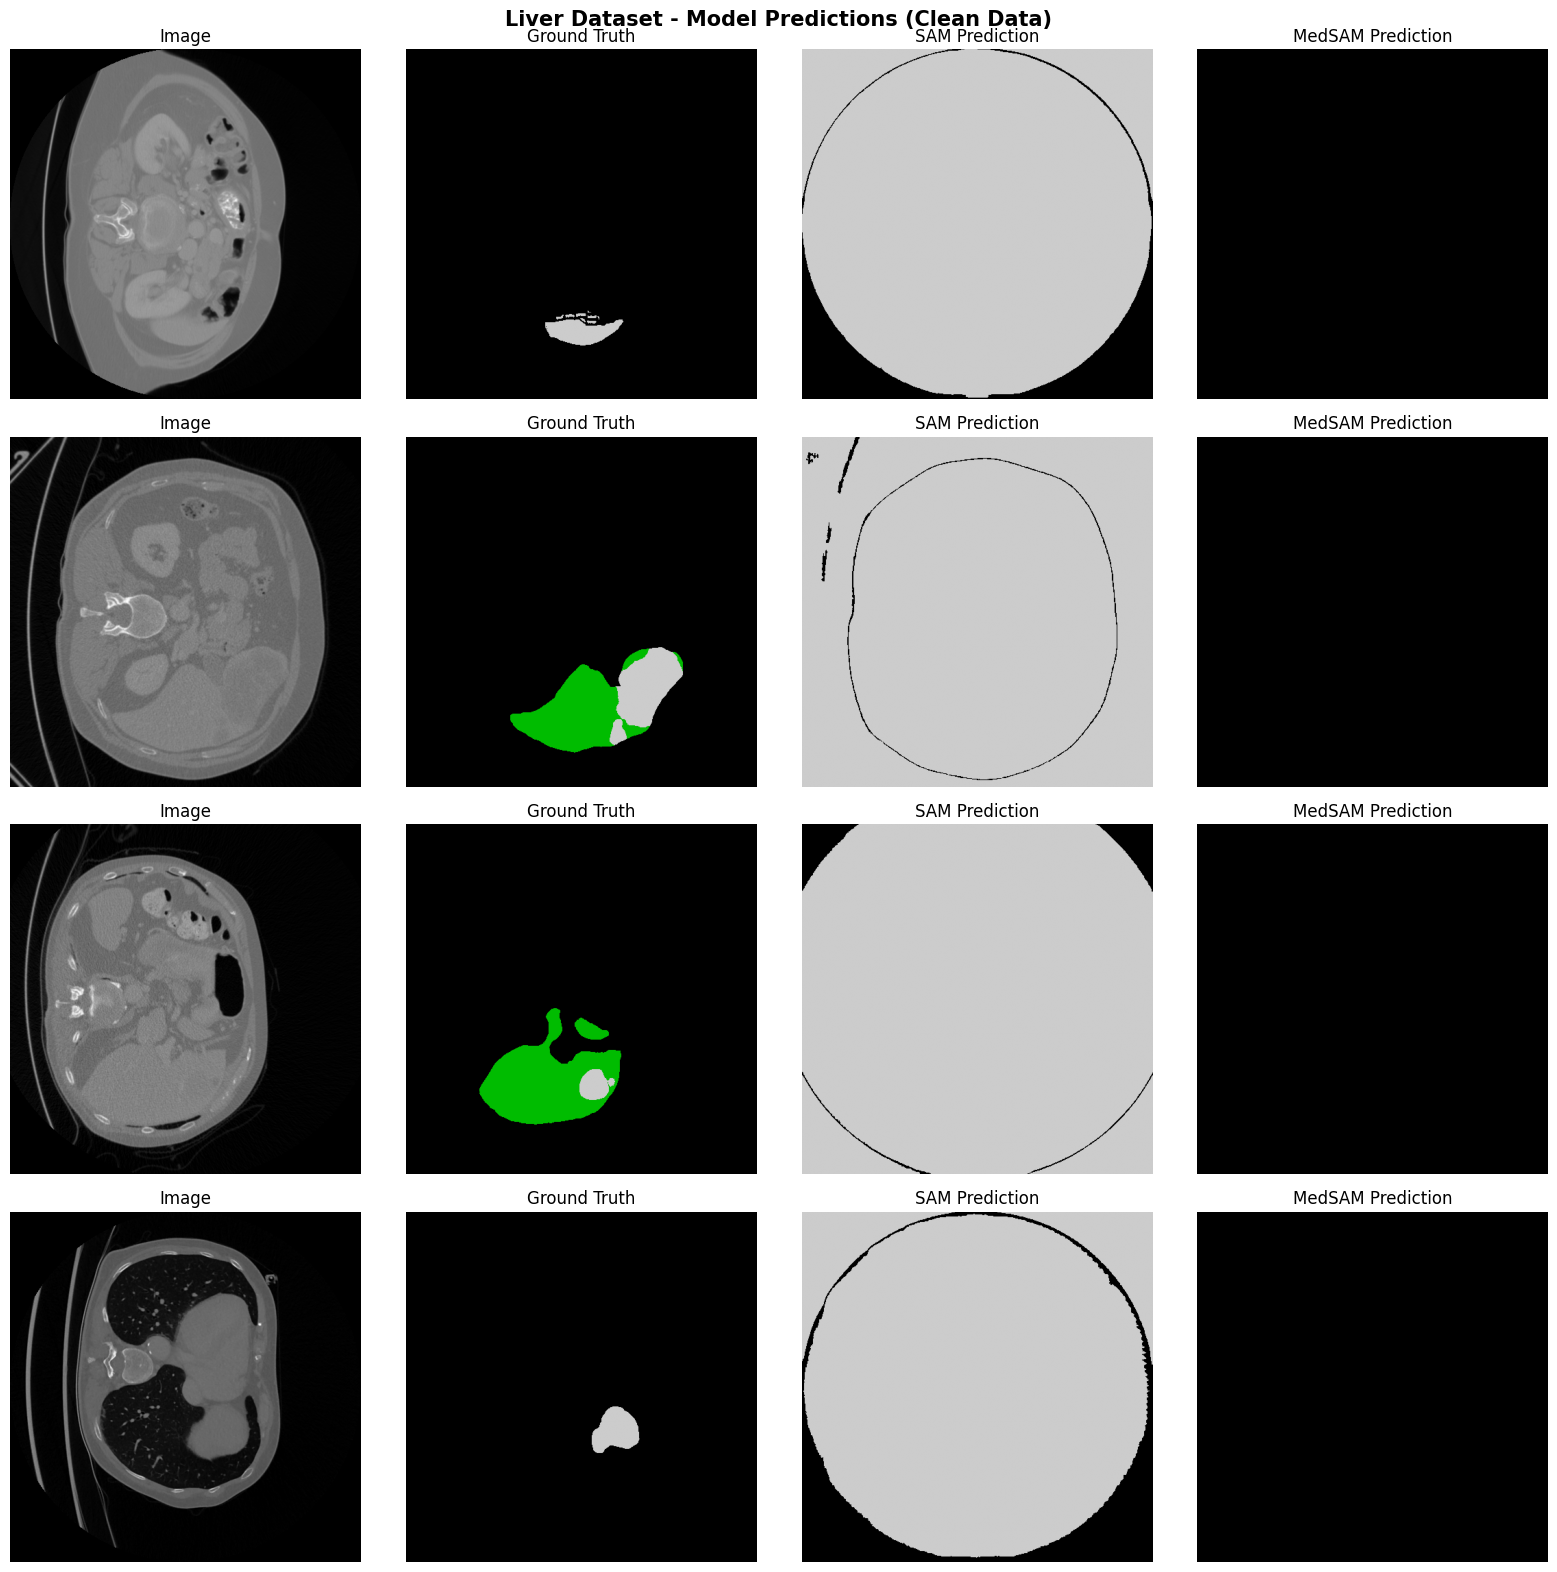

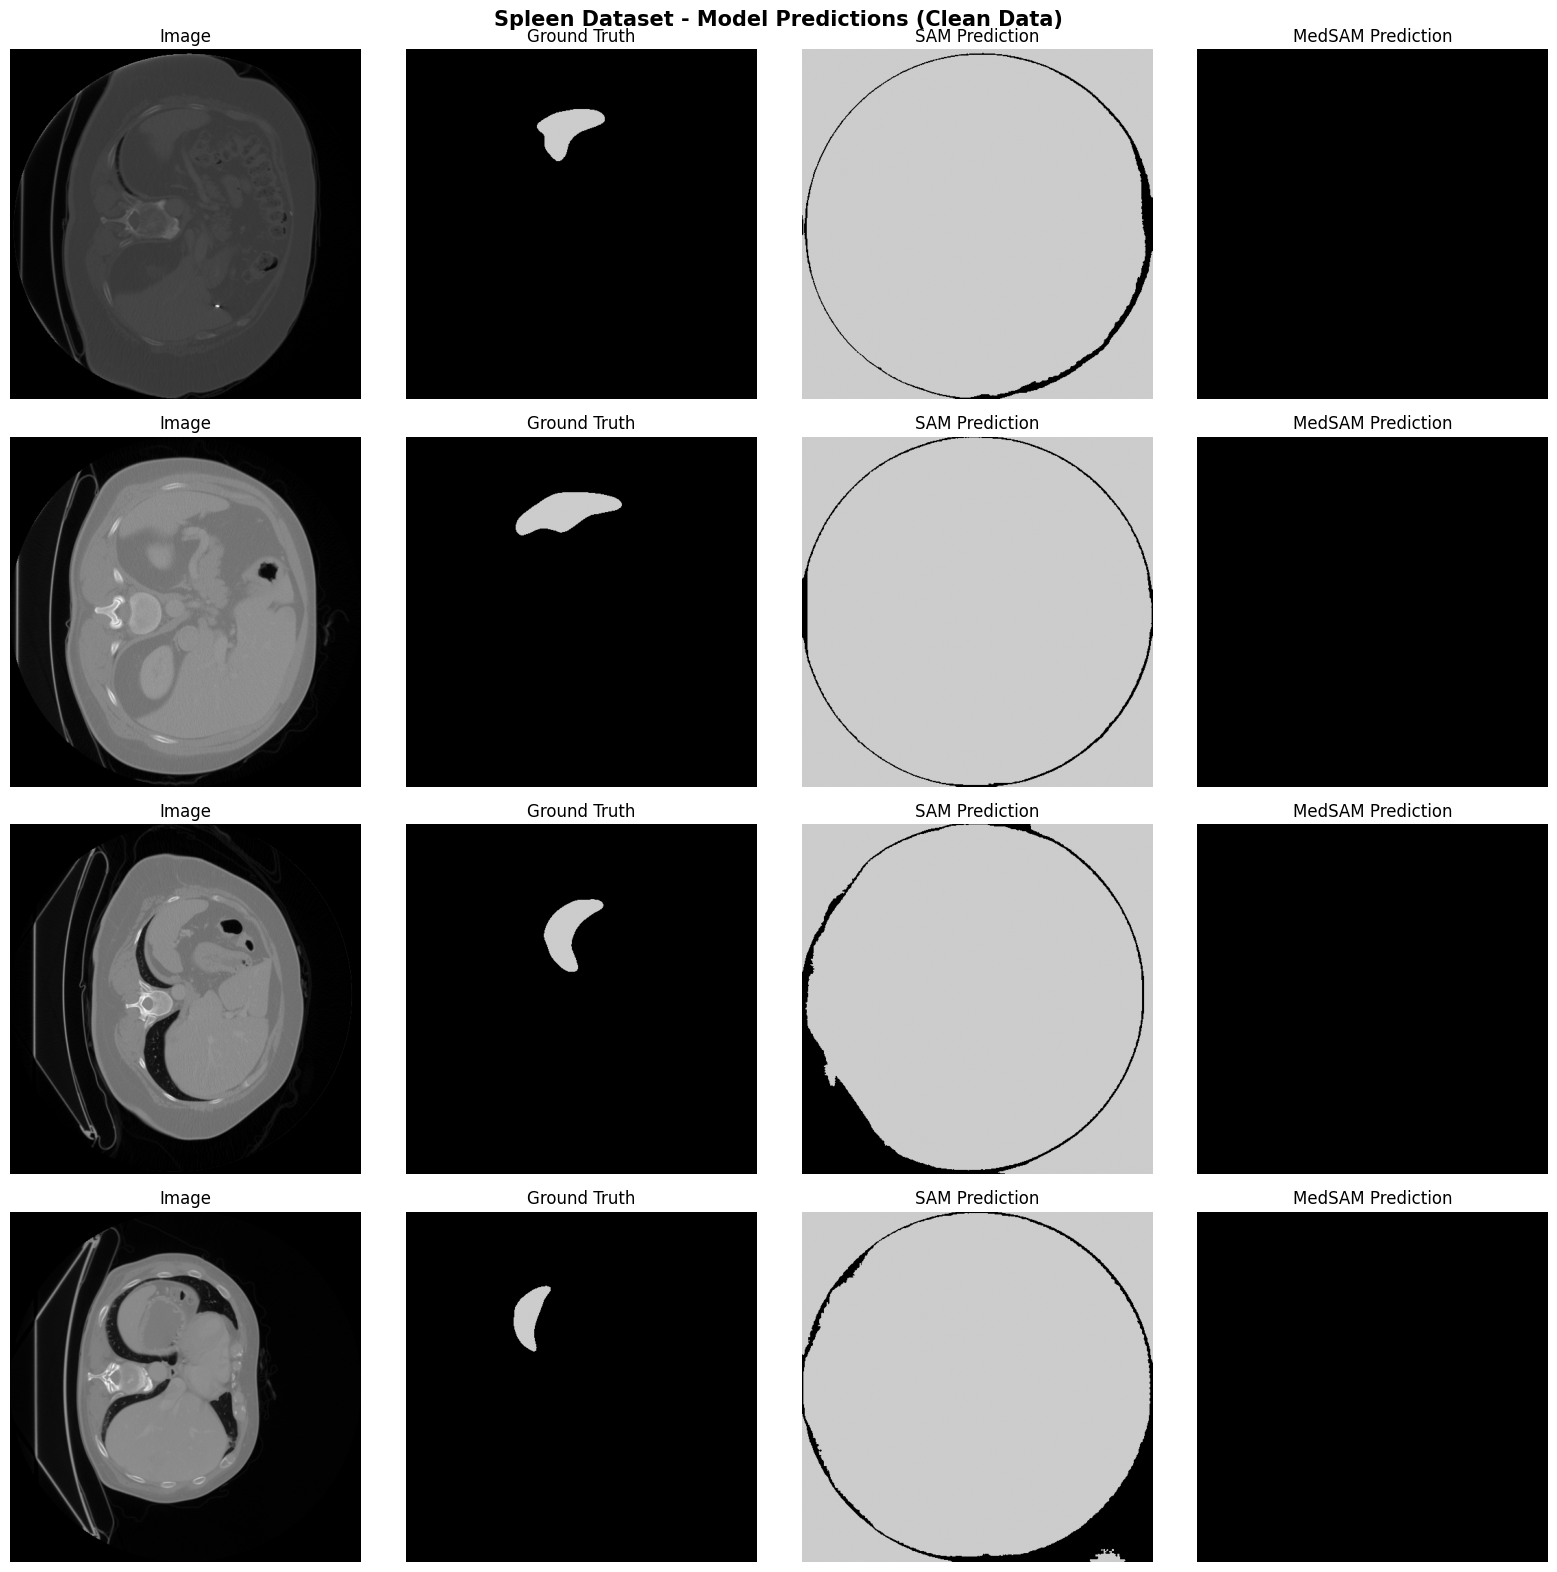

In [9]:
def visualize_predictions(images, ground_truth, predictions, dataset_name, num_samples=4):
    """
    Visualize predictions from all models.

    Args:
        images: Original images
        ground_truth: Ground truth labels
        predictions: Dictionary of predictions for each model
        dataset_name: Name for display
        num_samples: Number of samples to visualize
    """
    model_names = list(predictions.keys())
    num_cols = len(model_names) + 2

    fig, axes = plt.subplots(num_samples, num_cols, figsize=(4*num_cols, 4*num_samples))

    indices = np.linspace(0, len(images)-1, num_samples, dtype=int)

    for row, idx in enumerate(indices):
        axes[row, 0].imshow(images[idx], cmap='gray')
        axes[row, 0].set_title('Image', fontsize=12)
        axes[row, 0].axis('off')

        axes[row, 1].imshow(ground_truth[idx], cmap='nipy_spectral')
        axes[row, 1].set_title('Ground Truth', fontsize=12)
        axes[row, 1].axis('off')

        for col, model_name in enumerate(model_names):
            pred = predictions[model_name][idx]
            axes[row, col+2].imshow(pred, cmap='nipy_spectral')
            axes[row, col+2].set_title(f'{model_name} Prediction', fontsize=12)
            axes[row, col+2].axis('off')

    plt.suptitle(f'{dataset_name} Dataset - Model Predictions (Clean Data)',
                fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / f'{dataset_name.lower()}_clean_predictions.png',
               dpi=150, bbox_inches='tight')
    plt.show()

visualize_predictions(
    liver_data['images'],
    liver_data['labels'],
    liver_predictions,
    'Liver',
    num_samples=4
)

visualize_predictions(
    spleen_data['images'],
    spleen_data['labels'],
    spleen_predictions,
    'Spleen',
    num_samples=4
)

### 9. Quick Metrics Check

In [10]:
def calculate_dice(pred, gt):
    """
    Calculate Dice coefficient.

    Args:
        pred: Prediction mask
        gt: Ground truth mask

    Returns:
        Dice score
    """
    pred_binary = (pred > 0).astype(np.float32)
    gt_binary = (gt > 0).astype(np.float32)

    intersection = (pred_binary * gt_binary).sum()
    union = pred_binary.sum() + gt_binary.sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return (2.0 * intersection) / union

def compute_metrics_summary(predictions, ground_truth, model_names):
    """
    Compute quick metrics summary.
    """
    results = []

    for model_name in model_names:
        preds = predictions[model_name]

        dice_scores = []
        for pred, gt in zip(preds, ground_truth):
            dice = calculate_dice(pred, gt)
            dice_scores.append(dice)

        results.append({
            'Model': model_name,
            'Mean Dice': np.mean(dice_scores),
            'Std Dice': np.std(dice_scores),
            'Min Dice': np.min(dice_scores),
            'Max Dice': np.max(dice_scores)
        })

    return pd.DataFrame(results)

print("\n" + "="*60)
print("QUICK METRICS SUMMARY (Clean Data)")
print("="*60)

print("\nLiver Dataset:")
liver_metrics = compute_metrics_summary(
    liver_predictions,
    liver_data['labels'],
    list(liver_predictions.keys())
)
print(liver_metrics.to_string(index=False))

print("\nSpleen Dataset:")
spleen_metrics = compute_metrics_summary(
    spleen_predictions,
    spleen_data['labels'],
    list(spleen_predictions.keys())
)
print(spleen_metrics.to_string(index=False))
print("="*60)


QUICK METRICS SUMMARY (Clean Data)

Liver Dataset:
 Model  Mean Dice  Std Dice  Min Dice  Max Dice
   SAM   0.131258  0.106721  0.020983  0.410524
MedSAM   0.000000  0.000000  0.000000  0.000000

Spleen Dataset:
 Model  Mean Dice  Std Dice  Min Dice  Max Dice
   SAM   0.039555  0.017288  0.021061  0.096426
MedSAM   0.000000  0.000000  0.000000  0.000000


### 10. Save Summary

In [11]:
summary = {
    'liver_metrics': liver_metrics,
    'spleen_metrics': spleen_metrics
}

liver_metrics.to_csv(PREDICTIONS_PATH / 'liver_clean_metrics_summary.csv', index=False)
spleen_metrics.to_csv(PREDICTIONS_PATH / 'spleen_clean_metrics_summary.csv', index=False)

print(f"\nMetrics saved to {PREDICTIONS_PATH}")


Metrics saved to /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/predictions


---
## Notebook Complete

**Outputs:**
- Model predictions on clean data saved to `predictions/`
- Visualization comparisons
- Quick metrics summary

**Prediction Structure:**
```
predictions/
├── liver/
│   └── clean/
│       ├── sam/
│       └── medsam/
└── spleen/
    └── clean/
        ├── sam/
        └── medsam/
```

**Next Steps:**
- Proceed to Notebook 04 for inference on noisy data